# Portfolio Workflow

## Use the last week to determine current portfolio mix

In [1]:
from platform import python_version
import configparser
import logging.config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
import trading_factors_yahoo as alpha_factors
import ameritrade_functions as amc
import utils as utils

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('IndHoldingsAdjustement')
logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['IND']

# Which account are we interested in
masked_account_number = default_config['masked_account_number']
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories_yahoo.csv'

2022-12-10 20:11:44,035|IndHoldingsAdjustement|INFO|Python version: 3.8.15
2022-12-10 20:11:44,036|IndHoldingsAdjustement|INFO|Pandas version: 1.5.2


In [2]:
price_histories_file_name = default_config["DataDirectory"] + '/' + default_config["PriceHistoriesFileName"]
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
returns = alpha_factors.FactorReturns(price_histories).factor_data

ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
logger.info(f'AI_ALPHA_FACTORS_FILE|{ai_alpha_factors_file_name}')

beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config["BetaFactorsFileName"]
logger.info(f'BETA_FACTORS_FILE|{beta_factors_file_name}')

alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
logger.info(f'ALPHA_STOCKS|{len(alpha_vectors.columns)}')

2022-12-10 20:11:44,059|IndHoldingsAdjustement|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
2022-12-10 20:11:45,173|IndHoldingsAdjustement|INFO|PRICE_HISTORIES|2017-12-11 00:00:00|2022-12-09 00:00:00
2022-12-10 20:11:45,207|IndHoldingsAdjustement|INFO|AI_ALPHA_FACTORS_FILE|./data/alpha_vectors.csv
2022-12-10 20:11:45,207|IndHoldingsAdjustement|INFO|BETA_FACTORS_FILE|./data/daily_beta.pickle
2022-12-10 20:11:45,410|IndHoldingsAdjustement|INFO|ALPHA_STOCKS|501


In [3]:
risk_cap = float(default_config['risk_cap'])
weights_max = float(default_config['weights_max'])
weights_min = float(default_config['weights_min'])
logger.info(f'OPTIMIZATION|risk_cap|{risk_cap}')
logger.info(f'OPTIMIZATION|weights_max|{weights_max}')
logger.info(f'OPTIMIZATION|weights_min|{weights_min}')

2022-12-10 20:11:45,432|IndHoldingsAdjustement|INFO|OPTIMIZATION|risk_cap|0.018
2022-12-10 20:11:45,433|IndHoldingsAdjustement|INFO|OPTIMIZATION|weights_max|0.3
2022-12-10 20:11:45,434|IndHoldingsAdjustement|INFO|OPTIMIZATION|weights_min|0.0


In [4]:
reduced_stocks = utils.reduce_universe_by_sentiment(alpha_vectors.columns)

Tickers:   0%|          | 0/501 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/501 [00:00<?, ?News Table Items/s]

c:\users\hp-z440\anaconda projects\svi-trading-tools\tools\utils.py:338: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker', 'date']).mean().fillna(0)


In [5]:
# Error check to make sure we didn't reduce by too much

pct_red = len(reduced_stocks) / len(alpha_vectors.columns)
logger.info(f'SENTIMENT_REDUCTION|{pct_red:0.2f}|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
if pct_red < 0.50:
    logger.error(f'SENTIMENT_REDUCTION|OVER_REDUCED|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
    raise SystemExit

2022-12-10 20:15:18,878|IndHoldingsAdjustement|INFO|SENTIMENT_REDUCTION|0.87|501->436


In [6]:
final_alhpa_vectors = alpha_vectors[reduced_stocks]
logger.info(f'FINAL_ALPHA_STOCKS|{len(final_alhpa_vectors.columns)}')
opt_date = final_alhpa_vectors.index[-1]
start_of_returns = opt_date - pd.offsets.DateOffset(years=1)
final_beta_returns = returns[reduced_stocks].loc[start_of_returns:opt_date]
risk_model = alpha_factors.RiskModelPCA(final_beta_returns, 1, 20)
logger.info(f'OPT_DATE|{opt_date}')
alpha_vector = pd.DataFrame(final_alhpa_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

2022-12-10 20:15:18,917|IndHoldingsAdjustement|INFO|FINAL_ALPHA_STOCKS|436
2022-12-10 20:15:18,981|IndHoldingsAdjustement|INFO|OPT_DATE|2022-12-09 00:00:00


2022-12-10 20:15:31,503|IndHoldingsAdjustement|INFO|AJD_PORT_VARIANCE|0.01496619


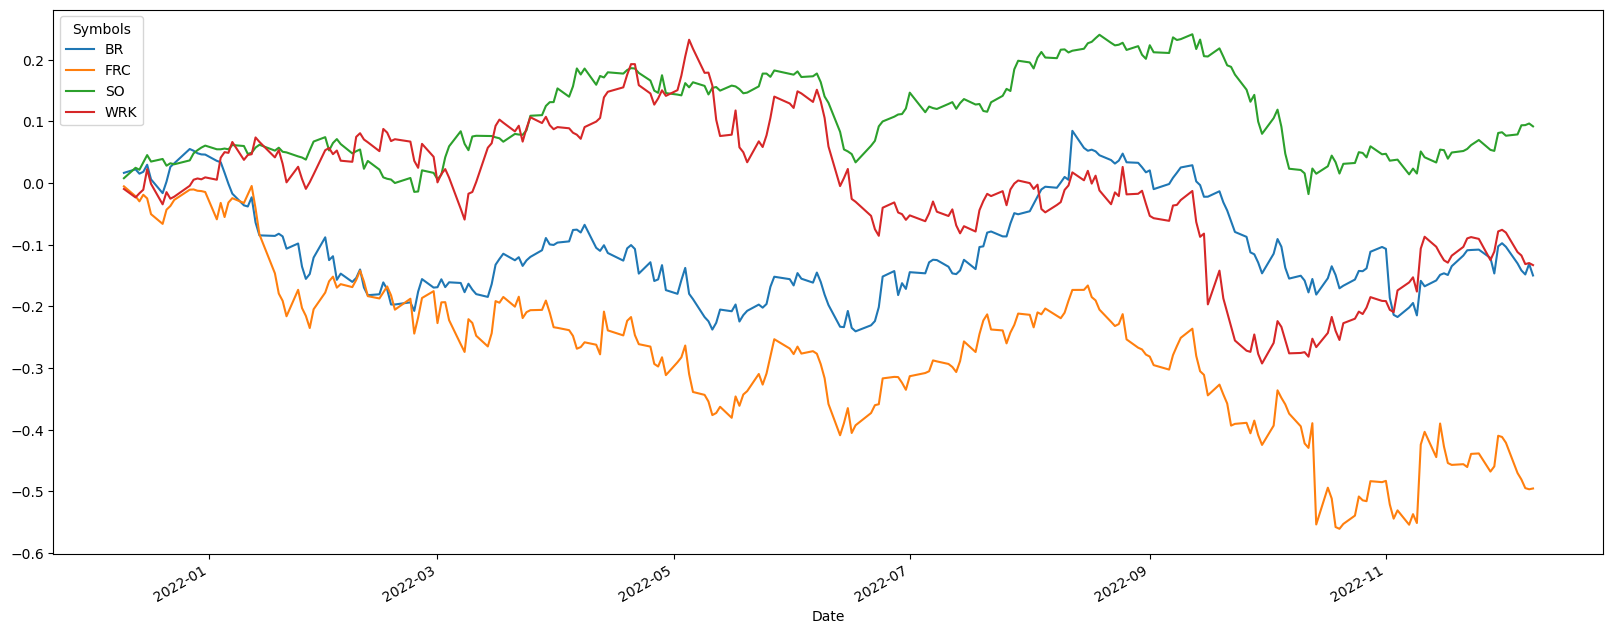

In [7]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 5.0]
returns[-252:][long_weights.index.to_list()].cumsum().plot(figsize=(20,8))
logger.info(f'AJD_PORT_VARIANCE|{risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [8]:
for index, row in long_weights.iterrows():
    logger.info(f'STOCK|{index:20}|HOLDING|{row.optimalWeights:2f}')

2022-12-10 20:15:31,876|IndHoldingsAdjustement|INFO|STOCK|BR                  |HOLDING|0.300000
2022-12-10 20:15:31,876|IndHoldingsAdjustement|INFO|STOCK|FRC                 |HOLDING|0.100000
2022-12-10 20:15:31,876|IndHoldingsAdjustement|INFO|STOCK|SO                  |HOLDING|0.300000
2022-12-10 20:15:31,876|IndHoldingsAdjustement|INFO|STOCK|WRK                 |HOLDING|0.300000


In [9]:
td_ameritrade = amc.AmeritradeRest()
display(td_ameritrade.get_quotes(list(long_weights.index.to_list())))

,assetType,assetMainType,cusip,assetSubType,symbol,description,bidPrice,bidSize,bidId,askPrice,...,regularMarketLastPrice,regularMarketLastSize,regularMarketNetChange,regularMarketTradeTimeInLong,netPercentChangeInDouble,markChangeInDouble,markPercentChangeInDouble,regularMarketPercentChangeInDouble,delayed,realtimeEntitled
BR,EQUITY,EQUITY,11133T103,,BR,"Broadridge Financial Solutions, Inc. Common Stock",80.80,200,P,299.99,...,142.11,0,0.0,1670630400002,0.2604,0.0,0.0,0.0,False,True
FRC,EQUITY,EQUITY,33616C100,,FRC,FIRST REPUBLIC BANK Common Stock,104.88,100,P,169.00,...,116.98,3532,0.0,1670630400003,0.0000,0.0,0.0,0.0,False,True
SO,EQUITY,EQUITY,842587107,,SO,Southern Company (The) Common Stock,67.75,100,P,68.50,...,68.36,4799,0.0,1670630400000,0.0731,0.0,0.0,0.0,False,True
WRK,EQUITY,EQUITY,96145D105,,WRK,Westrock Company Common Stock,33.70,400,P,38.00,...,35.88,1766,0.0,1670630400001,0.0000,0.0,0.0,0.0,False,True


Tickers:   0%|          | 0/4 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/4 [00:00<?, ?News Table Items/s]

C:\Users\HP-Z440\AppData\Local\Temp\ipykernel_6360\1254735451.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()


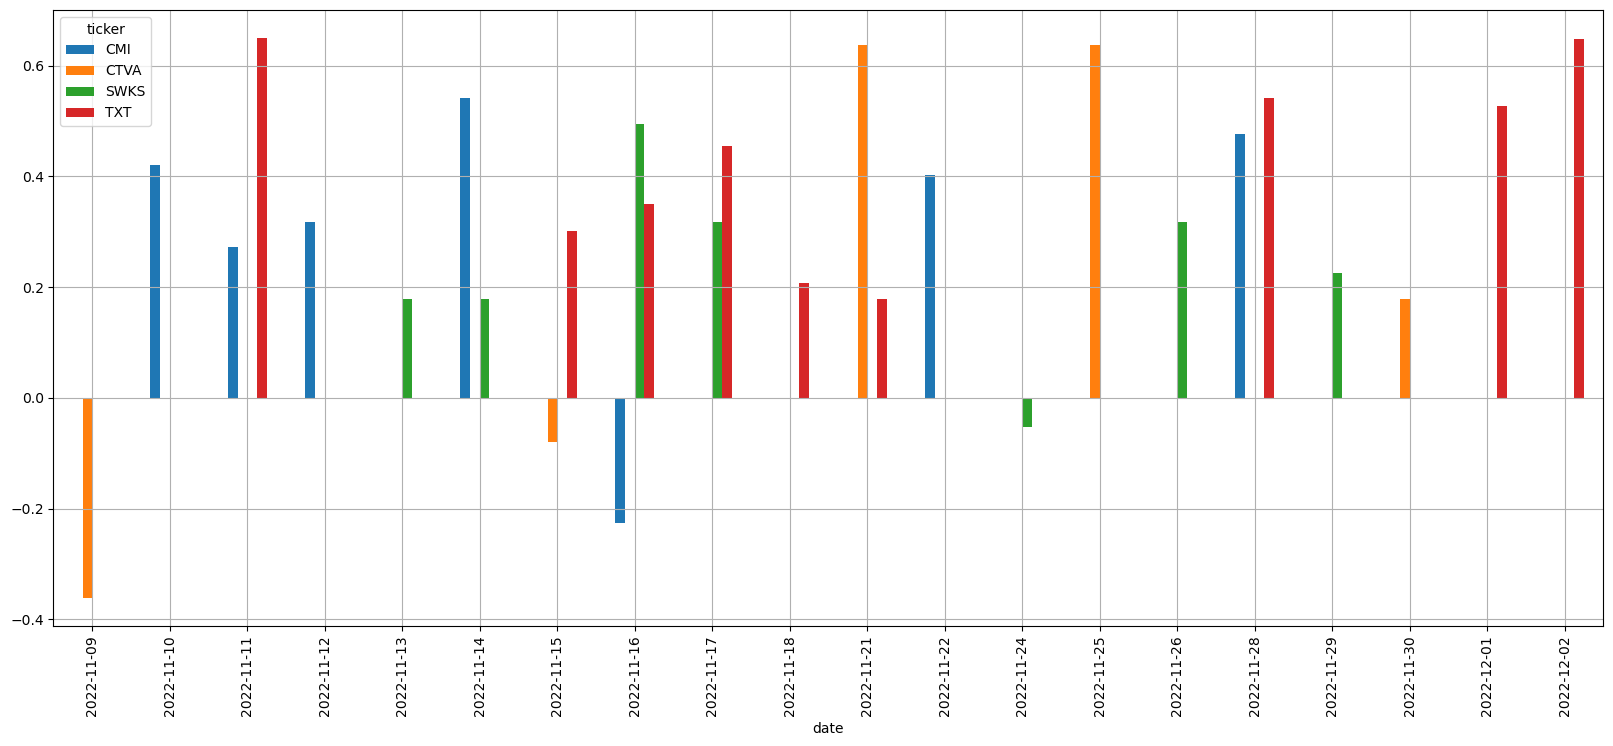

In [10]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

## First lets see which stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but I have not coded it yet.) You only need to do this if you
are going to use an existing Ameritrade account to define an initial set of stocks to analyze.

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

For security reasons, I sugges using environment variables to store your credential information. If you store them in property files, or just code them into your notebook, you risk sharing the information with others if you use GitHub or some other SCCS. This also makes it easier to have them availabe from project to project in your development environment

<span style="color:blue">Note: *Account numbers are masked for security purposes.*</span>

In [10]:
logger.info(f'TRADE_DATE|{datetime.today()}')

# Specific Portfolio Account
equity_investments_df = td_ameritrade.get_account_portfolio_data(masked_account_number, investment_type='EQUITY')
logger.info('Full Equity Portfolio:')
display(equity_investments_df)

2022-12-10 20:17:04,648|IndHoldingsAdjustement|INFO|TRADE_DATE|2022-12-10 20:17:04.648014
2022-12-10 20:17:04,926|IndHoldingsAdjustement|INFO|Full Equity Portfolio:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---9216 CTVA              0.0      66.78500             0.0   
         SWKS              0.0      93.41368             0.0   
         TXT               0.0      70.67000             0.0   
         FGPHF             0.0       0.21397             0.0   
         CMI               0.0     247.18000             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---9216 CTVA                     0.0                             0.0   
         SWKS                     0.0                             0.0   
         TXT                      0.0                             0.0   
         FGPHF                    0.0                             0.0   
         CMI                      0.0                             0.0   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---9216 CTVA             8.0                  8.0                   0.0   
         SWKS            19.0                 19.0                   0.0   
         TXT             23.0                 23.0                   0.0   
         FGPHF         5000.0               5000.0                   0.0   
         CMI              7.0                  7.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---9216 CTVA         503.92                  151.18   
         SWKS        1795.88                  538.76   
         TXT         1649.33                  494.80   
         FGPHF        378.05                    0.00   
         CMI         1666.98                  500.09   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---9216 CTVA                            8.0    EQUITY  22052L104           0   
         SWKS                           19.0    EQUITY  83088M102           0   
         TXT                            23.0    EQUITY  883203101           0   
         FGPHF                        5000.0    EQUITY  Q3860H107           0   
         CMI                             7.0    EQUITY  231021106           0   

                type  
account  symbol       
#---9216 CTVA      0  
         SWKS      0  
         TXT       0  
         FGPHF     0  
         CMI       0

In [11]:
total_portfolio_value = td_ameritrade.get_account_value(masked_account_number).round(2)
display(f'Account {masked_account_number} total value:  {total_portfolio_value}')

equity_investments_df = td_ameritrade.get_account_portfolio_data(masked_account_number, 'EQUITY')
port_equi_values = td_ameritrade.get_market_values(masked_account_number, 'EQUITY')
display(port_equi_values)
total_equity_value = td_ameritrade.get_account_value(masked_account_number, 'EQUITY').round(2)
display(f'Account {masked_account_number} equity value: {total_equity_value}')

port_weights_equity = td_ameritrade.get_portfolio_weights(masked_account_number, 'EQUITY')
display(port_weights_equity*100)

'Account #---9216 total value:  7097.54'

account   symbol
#---9216  CTVA       503.92
          SWKS      1795.88
          TXT       1649.33
          FGPHF      378.05
          CMI       1666.98
Name: marketValue, dtype: float64

'Account #---9216 equity value: 5994.16'

account   symbol
#---9216  CMI       27.810068
          CTVA       8.406849
          FGPHF      6.306972
          SWKS      29.960495
          TXT       27.515615
Name: marketValue, dtype: float64

In [12]:
long_term_stocks = default_config['long_term_stocks'].split()
equity_stock_symbols = td_ameritrade.get_investment_symbols(masked_account_number, 'EQUITY')

# Filter out non Equity investments
current_stocks = td_ameritrade.get_quotes(equity_stock_symbols).query('assetType == "EQUITY"').index.tolist()
stocks_to_sell = equity_investments_df[equity_investments_df.index.get_level_values('symbol').isin(current_stocks)]
stocks_to_sell = stocks_to_sell[~stocks_to_sell.index.get_level_values('symbol').isin(long_term_stocks)]
logger.info(f'Stocks to sell:')
display(stocks_to_sell)

2022-12-10 20:18:53,842|IndHoldingsAdjustement|INFO|Stocks to sell:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---9216 CTVA              0.0      66.78500             0.0   
         SWKS              0.0      93.41368             0.0   
         TXT               0.0      70.67000             0.0   
         CMI               0.0     247.18000             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---9216 CTVA                     0.0                             0.0   
         SWKS                     0.0                             0.0   
         TXT                      0.0                             0.0   
         CMI                      0.0                             0.0   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---9216 CTVA             8.0                  8.0                   0.0   
         SWKS            19.0                 19.0                   0.0   
         TXT             23.0                 23.0                   0.0   
         CMI              7.0                  7.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---9216 CTVA         503.92                  151.18   
         SWKS        1795.88                  538.76   
         TXT         1649.33                  494.80   
         CMI         1666.98                  500.09   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---9216 CTVA                            8.0    EQUITY  22052L104           0   
         SWKS                           19.0    EQUITY  83088M102           0   
         TXT                            23.0    EQUITY  883203101           0   
         CMI                             7.0    EQUITY  231021106           0   

                type  
account  symbol       
#---9216 CTVA      0  
         SWKS      0  
         TXT       0  
         CMI       0

In [14]:
cash_equivelants_df = td_ameritrade.get_account_portfolio_data(masked_account_number, 'CASH_EQUIVALENT')
amount_for_trading = cash_equivelants_df.marketValue.sum() + stocks_to_sell.marketValue.sum()
amount_for_trading

6719.490000000001

In [50]:
investment_base = 1000
investment_amount = math.floor(amount_for_trading / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

Amount to invest: 6000


In [20]:
stocks_to_trade = long_weights.index.to_list() + list(stocks_to_sell.index.get_level_values('symbol'))
quotes_for_stocks = td_ameritrade.get_quotes(stocks_to_trade)

In [23]:
quotes_for_stocks[['bidPrice', 'askPrice', 'regularMarketLastPrice']]

,bidPrice,askPrice,regularMarketLastPrice
BR,80.80,299.99,142.11
FRC,104.88,169.00,116.98
SO,67.75,68.50,68.36
WRK,33.70,38.00,35.88
CTVA,62.50,69.07,62.99
SWKS,93.98,94.85,94.52
TXT,70.75,71.70,71.71
CMI,238.00,250.54,238.14


In [80]:
weights_for_trade = optimal_weights.loc[stocks_to_trade].copy()
weights_for_trade['optimalWeights'] = weights_for_trade['optimalWeights'].map(lambda x: 0 if x < 0.05 else x)
weights_for_trade

,optimalWeights
BR,0.3
FRC,0.1
SO,0.3
WRK,0.3
CTVA,0.0
SWKS,0.0
TXT,0.0
CMI,0.0


In [81]:
weights_for_trade = pd.concat([weights_for_trade, quotes_for_stocks['regularMarketLastPrice']], axis=1)

In [82]:
current_holdings = td_ameritrade.get_holdings(masked_account_number, symbols=stocks_to_trade)
current_holdings = current_holdings.droplevel('account')
current_holdings

,marketValue,longQuantity
symbol,,
BR,0.00,0.0
CMI,1666.98,7.0
CTVA,503.92,8.0
FRC,0.00,0.0
SO,0.00,0.0
SWKS,1795.88,19.0
TXT,1649.33,23.0
WRK,0.00,0.0


In [83]:
print(f'Current investment amount: {investment_amount}')
min_shares_accepted = 5
weights_for_trade['amount'] = (weights_for_trade['optimalWeights'] * investment_amount).round(0)
weights_for_trade['marketValue'] = current_holdings['marketValue']
weights_for_trade['buy/sell'] = (weights_for_trade['marketValue'] - weights_for_trade['amount']) * -1
weights_for_trade['existingShares'] = current_holdings['longQuantity']
weights_for_trade['deltaShares'] = (weights_for_trade['buy/sell'] / weights_for_trade['regularMarketLastPrice']).round(0)
weights_for_trade['deltaMarketValue'] = (weights_for_trade['deltaShares'] * weights_for_trade['regularMarketLastPrice'])
weights_for_trade['totalShares'] = (weights_for_trade['existingShares'] + weights_for_trade['deltaShares'])
weights_for_trade['totalMarketValue'] = (weights_for_trade['totalShares'] * weights_for_trade['regularMarketLastPrice'])
weights_for_trade

Current investment amount: 6000


,optimalWeights,regularMarketLastPrice,amount,marketValue,buy/sell,existingShares,deltaShares,deltaMarketValue,totalShares,totalMarketValue
BR,0.3,142.11,1800.0,0.00,1800.00,0.0,13.0,1847.43,13.0,1847.43
FRC,0.1,116.98,600.0,0.00,600.00,0.0,5.0,584.90,5.0,584.90
SO,0.3,68.36,1800.0,0.00,1800.00,0.0,26.0,1777.36,26.0,1777.36
WRK,0.3,35.88,1800.0,0.00,1800.00,0.0,50.0,1794.00,50.0,1794.00
CTVA,0.0,62.99,0.0,503.92,-503.92,8.0,-8.0,-503.92,0.0,0.00
SWKS,0.0,94.52,0.0,1795.88,-1795.88,19.0,-19.0,-1795.88,0.0,0.00
TXT,0.0,71.71,0.0,1649.33,-1649.33,23.0,-23.0,-1649.33,0.0,0.00
CMI,0.0,238.14,0.0,1666.98,-1666.98,7.0,-7.0,-1666.98,0.0,0.00


In [84]:
too_few_to_trade = weights_for_trade.query('deltaShares > 0 & deltaShares < @min_shares_accepted').index

Index([], dtype='object')

In [85]:
weights_for_trade.drop(index=too_few_to_trade, inplace =True)

In [86]:
weights_for_trade

,optimalWeights,regularMarketLastPrice,amount,marketValue,buy/sell,existingShares,deltaShares,deltaMarketValue,totalShares,totalMarketValue
BR,0.3,142.11,1800.0,0.00,1800.00,0.0,13.0,1847.43,13.0,1847.43
FRC,0.1,116.98,600.0,0.00,600.00,0.0,5.0,584.90,5.0,584.90
SO,0.3,68.36,1800.0,0.00,1800.00,0.0,26.0,1777.36,26.0,1777.36
WRK,0.3,35.88,1800.0,0.00,1800.00,0.0,50.0,1794.00,50.0,1794.00
CTVA,0.0,62.99,0.0,503.92,-503.92,8.0,-8.0,-503.92,0.0,0.00
SWKS,0.0,94.52,0.0,1795.88,-1795.88,19.0,-19.0,-1795.88,0.0,0.00
TXT,0.0,71.71,0.0,1649.33,-1649.33,23.0,-23.0,-1649.33,0.0,0.00
CMI,0.0,238.14,0.0,1666.98,-1666.98,7.0,-7.0,-1666.98,0.0,0.00


In [53]:
weights_for_trade.totalMarketValue.sum()

6003.6900000000005

In [52]:
account_number = td_ameritrade.unmask_account(masked_account_number)

for symbol, row in weights_for_trade.iterrows():
    if row.deltaShares > 0:
        instruction = 'BUY'
        quantity = row.deltaShares
    else:
        instruction = 'SELL'
        quantity = abs(row.deltaShares)
        
    order = amc.create_limit_order(account_number, symbol, 'EQUITY', quantity, instruction, 'NORMAL', 'DAY', row.regularMarketLastPrice)
    td_ameritrade.place_order(order)

Placed LIMIT BUY order on #---9216 for 13.0 shares of BR
Placed LIMIT BUY order on #---9216 for 5.0 shares of FRC
Placed LIMIT BUY order on #---9216 for 26.0 shares of SO
Placed LIMIT BUY order on #---9216 for 50.0 shares of WRK
Placed LIMIT SELL order on #---9216 for 8.0 shares of CTVA
Placed LIMIT SELL order on #---9216 for 19.0 shares of SWKS
Placed LIMIT SELL order on #---9216 for 23.0 shares of TXT
Placed LIMIT SELL order on #---9216 for 7.0 shares of CMI


### Submit and montior sell orders

In [14]:
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)
sell_result = td_ameritrade.place_bulk_sell_orders(account_number, stocks_to_sell)

Placing SELL order on #---9216 for 33.0 shares of OKE...
Placed SELL order on #---9216 for 33.0 shares of OKE
Placing SELL order on #---9216 for 35.0 shares of UAL...
Placed SELL order on #---9216 for 35.0 shares of UAL
Placing SELL order on #---9216 for 24.0 shares of GRMN...
Placed SELL order on #---9216 for 24.0 shares of GRMN


In [ ]:
while True:
    td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
    td_ameritrade.authenticate()
    account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
    equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
    stocks_with_sell_orders = equity_investments_df[equity_investments_df['symbol'].isin(stocks_to_sell.symbol.values)]
    if len(stocks_with_sell_orders[stocks_with_sell_orders.longQuantity >= 1]) == 0:
        break
    logger.info(f'\rStocks to sell|{stocks_with_sell_orders.symbol.values}')
    time.sleep(60)
    
logger.info(f'\rAll stocks sold|{stocks_to_sell.symbol.values}')


In [15]:
account_balances = td_ameritrade.parse_accounts().loc[masked_account_number]
display(account_balances)
print(account_balances.currentBalances_cashBalance)
print(account_balances.currentBalances_moneyMarketFund)
available_cash = account_balances.currentBalances_cashBalance + account_balances.currentBalances_moneyMarketFund
logger.info(f'INVESTMENT_AMT|{available_cash}')

initialBalances_cashBalance           0.000000
initialBalances_totalCash             0.000000
initialBalances_equity             6740.270000
initialBalances_moneyMarketFund     722.840000
currentBalances_cashBalance        6034.070000
currentBalances_equity             6756.910000
currentBalances_moneyMarketFund     722.840000
current_return                        0.002466
Name: #---9216, dtype: float64

6034.07
722.84
2022-12-05 09:50:29,809|IndHoldingsAdjustement|INFO|INVESTMENT_AMT|6756.91


In [16]:
print(f'Available cash  : {available_cash}')
investment_base = 1000
investment_amount = math.floor(available_cash / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

Available cash  : 6756.91
Amount to invest: 6000


In [17]:
long_weights

,optimalWeights
CMI,0.300000
CTVA,0.089973
SWKS,0.300000
TXT,0.274489


In [18]:
print(datetime.today())
print(f'Initial investment amount: {investment_amount}')
nearest_base = 5
min_shares = 5
long_quotes = td_ameritrade.get_quotes(long_weights.index.to_list())
long_shares = long_quotes['regularMarketLastPrice'].to_frame()
long_shares['optimalWeights'] = long_weights['optimalWeights']
long_shares['invest_amount'] = (long_shares['optimalWeights'] * investment_amount).round(0)
long_shares['shares'] = (long_shares['invest_amount'] / long_shares['regularMarketLastPrice']).astype(int)
display(long_shares)

# Remove symbols that are less than min and re-compute

final_long_shares = long_shares.query('shares >= @min_shares').copy()
final_long_shares['optimalWeights'] = final_long_shares['optimalWeights'] / final_long_shares['optimalWeights'].sum(axis=0)
final_long_shares['invest_amount'] = (final_long_shares['optimalWeights'] * investment_amount).round(0)
final_long_shares['shares'] = (final_long_shares['invest_amount'] / final_long_shares['regularMarketLastPrice']).astype(int)
final_long_shares['cost'] = final_long_shares['shares'] * final_long_shares['regularMarketLastPrice']
display(final_long_shares)
print(f'Total cost: {final_long_shares.cost.sum()}')


2022-12-05 09:50:46.419578
Initial investment amount: 6000


,regularMarketLastPrice,optimalWeights,invest_amount,shares
CMI,249.75,0.300000,1800.0,7
CTVA,67.31,0.089973,540.0,8
SWKS,93.96,0.300000,1800.0,19
TXT,71.30,0.274489,1647.0,23


,regularMarketLastPrice,optimalWeights,invest_amount,shares,cost
CMI,249.75,0.311054,1866.0,7,1748.25
CTVA,67.31,0.093288,560.0,8,538.48
SWKS,93.96,0.311054,1866.0,19,1785.24
TXT,71.30,0.284604,1708.0,23,1639.90


Total cost: 5711.87


### Place buy orders

In [19]:
display(td_ameritrade.get_quotes(long_weights.index.to_list()))
td_ameritrade.get_fundamental(list(final_long_shares.index))

,assetType,assetMainType,cusip,assetSubType,symbol,description,bidPrice,bidSize,bidId,askPrice,...,regularMarketLastPrice,regularMarketLastSize,regularMarketNetChange,regularMarketTradeTimeInLong,netPercentChangeInDouble,markChangeInDouble,markPercentChangeInDouble,regularMarketPercentChangeInDouble,delayed,realtimeEntitled
CMI,EQUITY,EQUITY,231021106,,CMI,Cummins Inc. Common Stock,247.13,100,P,249.70,...,249.75,1109,0.0,1670025600003,-1.0531,-0.05,-0.0200,0.0,True,False
CTVA,EQUITY,EQUITY,22052L104,,CTVA,"Corteva, Inc. Common Stock",66.79,500,Y,67.68,...,67.31,2393,0.0,1670025600002,0.6950,0.00,0.0000,0.0,True,False
SWKS,EQUITY,EQUITY,83088M102,,SWKS,"Skyworks Solutions, Inc. - Common Stock",92.95,300,P,94.65,...,93.96,1713,0.0,1670014800497,-0.2448,0.00,0.0000,0.0,True,False
TXT,EQUITY,EQUITY,883203101,,TXT,Textron Inc. Common Stock,70.05,100,Z,71.25,...,71.30,1979,0.0,1670025600001,-0.7013,-0.05,-0.0701,0.0,True,False


,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,883203101,TXT,Textron Inc. Common Stock,NYSE,EQUITY,79.450,57.110,0.08,0.11,2022-12-08 00:00:00.000,...,8.78702,0.0,0.0,0.0,0.02,2023-01-01 00:00:00.000,1.51071,1041570.0,1041571.0,27385190.0
1,22052L104,CTVA,"Corteva, Inc. Common Stock",NYSE,EQUITY,68.430,43.740,0.60,0.89,2022-11-10 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.15,2022-12-15 00:00:00.000,0.74259,2348250.0,2348246.0,69944340.0
2,83088M102,SWKS,"Skyworks Solutions, Inc. - Common Stock",NASDAQ,EQUITY,164.470,76.160,2.48,2.64,2022-11-21 00:00:00.000,...,8.98323,0.0,0.0,0.0,0.62,2022-12-13 00:00:00.000,1.21128,1770670.0,1770666.0,43414900.0
3,231021106,CMI,Cummins Inc. Common Stock,NYSE,EQUITY,254.085,184.275,6.28,2.51,2022-11-17 00:00:00.000,...,7.78675,0.0,0.0,0.0,1.57,2022-12-01 00:00:00.000,1.05245,919450.0,919449.0,19710120.0


In [20]:
print(datetime.today())
#td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
#td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)

for index, row in final_long_shares.iterrows():
    fundamental = td_ameritrade.get_fundamental([index])
    print(f'Placing BUY order on {account_number} for {row.shares} shares of {index}:{fundamental.loc[0].assetType}...')
    result = td_ameritrade.place_order(account_number, index, fundamental.loc[0].assetType, row.shares, 'BUY')

2022-12-05 09:51:01.637956
Placing BUY order on 755579216 for 7.0 shares of CMI:EQUITY...
Placed BUY order on #---9216 for 7.0 shares of CMI
Placing BUY order on 755579216 for 8.0 shares of CTVA:EQUITY...
Placed BUY order on #---9216 for 8.0 shares of CTVA
Placing BUY order on 755579216 for 19.0 shares of SWKS:EQUITY...
Placed BUY order on #---9216 for 19.0 shares of SWKS
Placing BUY order on 755579216 for 23.0 shares of TXT:EQUITY...
Placed BUY order on #---9216 for 23.0 shares of TXT


In [ ]:
number_of_years = 5
portfolio_price_histories = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_price_histories(list(long_shares.index), datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
portfolio_close = utils.get_close_values(portfolio_price_histories)
utils.compute_log_returns(portfolio_close)[-5:].cumsum().plot()

## import ameritrade_functions as amc

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_accounts().loc[masked_account_number]